INTERMEDIATE LEVEL - TASK 1: FEATURE ENGINEERING FOR SALES DATA

📥 CARGANDO DATASET...
✓ Datos limpios cargados exitosamente
📊 Dataset cargado: (3000888, 9)
📅 Rango de fechas: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

🛠️ CREANDO NUEVAS CARACTERÍSTICAS TEMPORALES
📅 Creando características básicas de fecha...
🕒 Creando características avanzadas de tiempo...
🔄 Creando características cíclicas...
📈 Creando características de tendencia...
✅ Características temporales creadas: 23

⏪ CREANDO VARIABLES DE RETARDO (LAG FEATURES)
🔄 Aplicando lags por tienda y familia...
🔄 Creando lags para promociones...
✅ Variables de retardo creadas: 9

📊 CREANDO VARIABLES DE MEDIA MÓVIL
🔄 Calculando medias móviles por tienda y familia...
📈 Creando características de diferencia...
✅ Características de media móvil creadas: 30

🎄 CREANDO BANDERAS PARA FERIADOS
🎯 Creando características de eventos especiales...
⏳ Calculando días hasta/desde feriados...
✅ Características de feriados creadas: 6

📊 VERIFICANDO COR

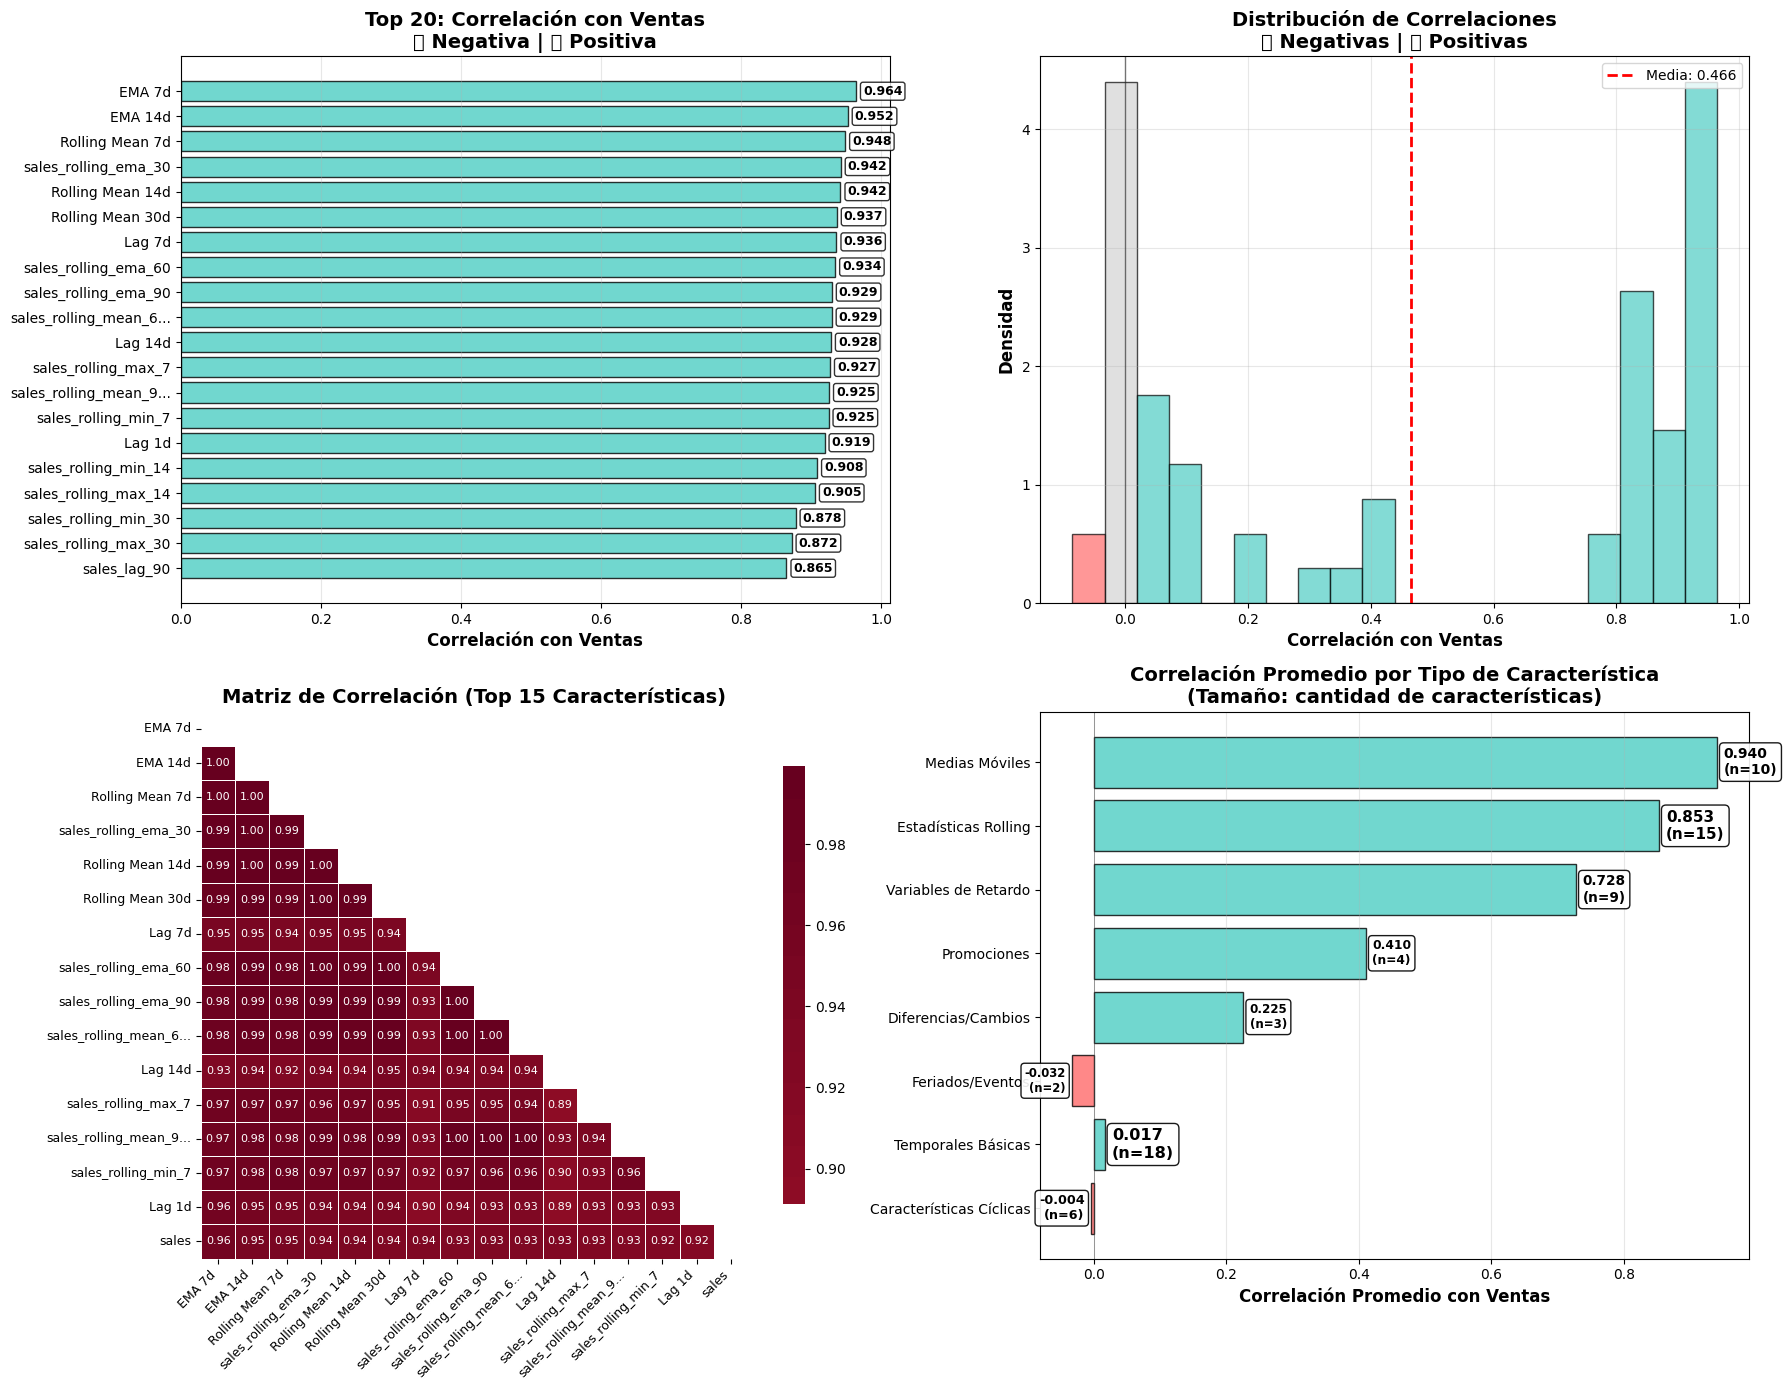


📈 GRÁFICO ADICIONAL: EVOLUCIÓN TEMPORAL


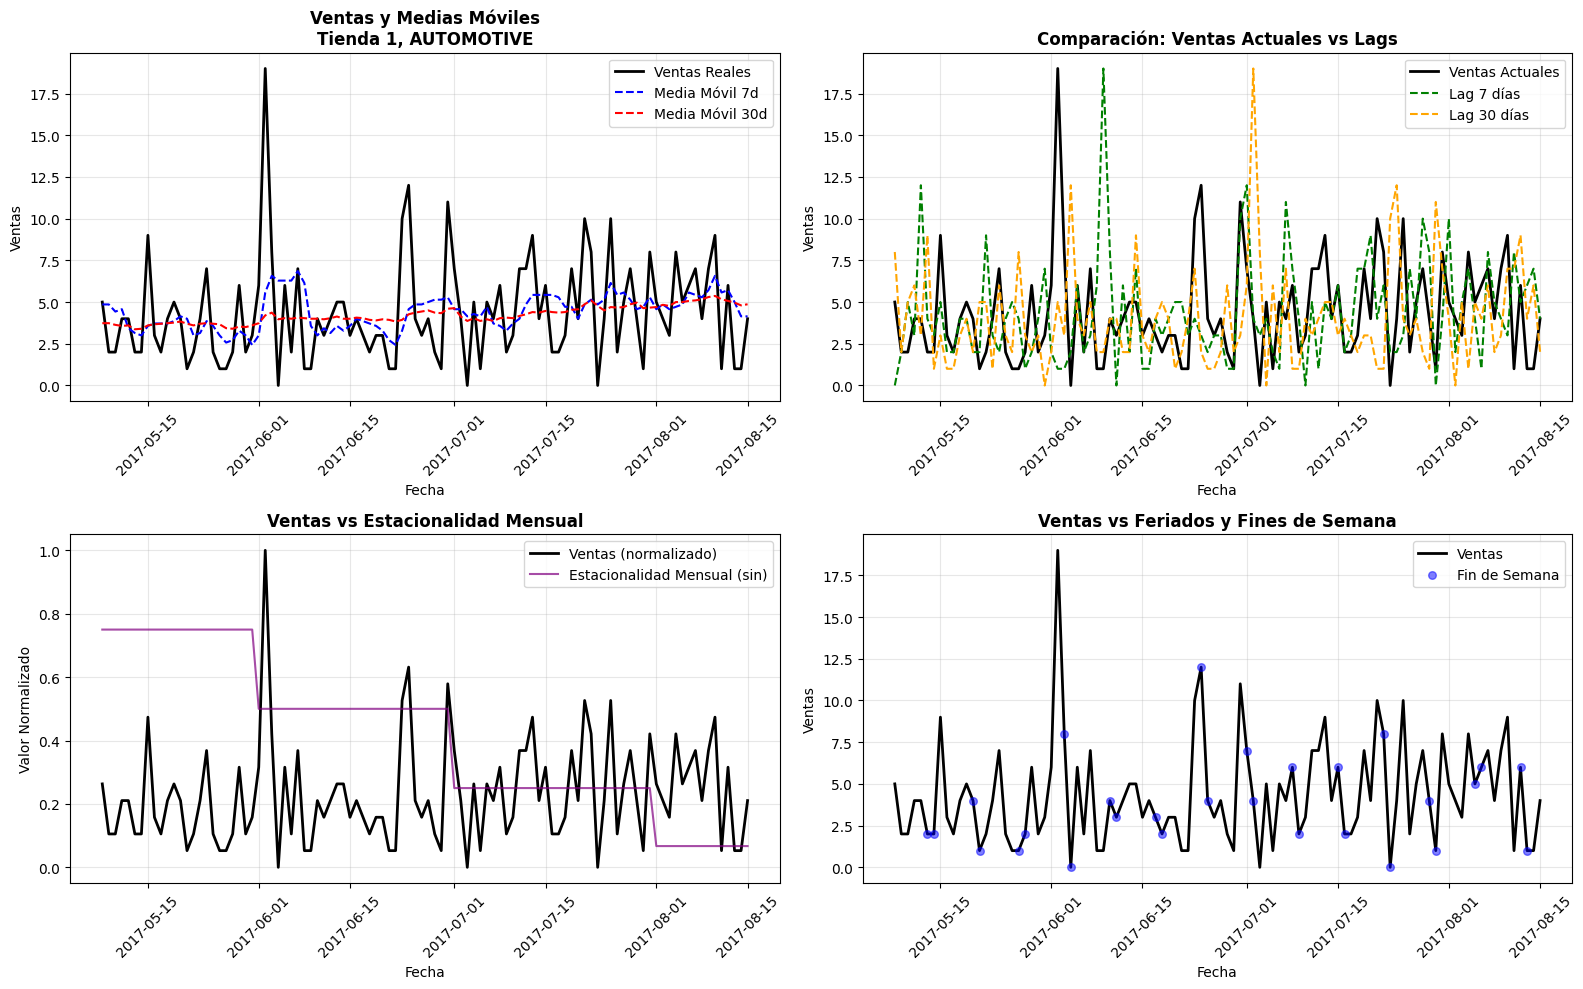

In [1]:
# 1️⃣ Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.feature_selection import mutual_info_regression

print("=" * 70)
print("INTERMEDIATE LEVEL - TASK 1: FEATURE ENGINEERING FOR SALES DATA")
print("=" * 70)

# 2️⃣ Cargar dataset
print("\n📥 CARGANDO DATASET...")

# Configurar rutas
base_dir = r"C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT"
processed_path = os.path.join(base_dir, "data", "processed")
features_path = os.path.join(base_dir, "features")
os.makedirs(features_path, exist_ok=True)

try:
    # Intentar cargar datos procesados
    clean_data_path = os.path.join(processed_path, 'sales_data_cleaned.csv')
    df = pd.read_csv(clean_data_path, parse_dates=['date'])
    print("✓ Datos limpios cargados exitosamente")
except FileNotFoundError:
    try:
        # Cargar datos originales
        raw_path = os.path.join(base_dir, "data", "raw", "train.csv")
        df = pd.read_csv(raw_path, parse_dates=['date'])
        print("✓ Datos originales cargados")
    except FileNotFoundError:
        print("❌ No se encontraron datos. Creando datos de ejemplo...")
        # Crear datos de ejemplo
        dates = pd.date_range('2020-01-01', periods=1000, freq='D')
        np.random.seed(42)
        df = pd.DataFrame({
            'date': dates,
            'store_nbr': np.random.randint(1, 10, len(dates)),
            'family': np.random.choice(['GROCERY', 'DAIRY', 'CLEANING'], len(dates)),
            'sales': np.random.normal(1000, 300, len(dates)) + 
                     np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 200,
            'onpromotion': np.random.randint(0, 20, len(dates))
        })

print(f"📊 Dataset cargado: {df.shape}")
print(f"📅 Rango de fechas: {df['date'].min()} to {df['date'].max()}")

# Ordenar por fecha para asegurar consistencia temporal
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# 3️⃣ Crear nuevas características
print("\n" + "=" * 70)
print("🛠️ CREANDO NUEVAS CARACTERÍSTICAS TEMPORALES")
print("=" * 70)

# Características básicas de fecha
print("📅 Creando características básicas de fecha...")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)

# Características avanzadas de tiempo
print("🕒 Creando características avanzadas de tiempo...")
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

# Características cíclicas (para capturar estacionalidad)
print("🔄 Creando características cíclicas...")
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Tendencia temporal
print("📈 Creando características de tendencia...")
df['days_from_start'] = (df['date'] - df['date'].min()).dt.days
df['months_from_start'] = df['days_from_start'] // 30

print(f"✅ Características temporales creadas: {len([col for col in df.columns if col not in ['date', 'store_nbr', 'family', 'sales', 'onpromotion']])}")

# 4️⃣ Crear variables de retardo (lag features)
print("\n" + "=" * 70)
print("⏪ CREANDO VARIABLES DE RETARDO (LAG FEATURES)")
print("=" * 70)

# Función para crear lags de manera segura por grupo
def create_lag_features(group, lags=[1, 7, 14, 30, 60, 90]):
    """Crear características de retardo para un grupo de series temporales"""
    group = group.sort_values('date')
    for lag in lags:
        group[f'sales_lag_{lag}'] = group['sales'].shift(lag)
    return group

print("🔄 Aplicando lags por tienda y familia...")
df = df.groupby(['store_nbr', 'family']).apply(create_lag_features).reset_index(drop=True)

# Crear lags para promociones también
print("🔄 Creando lags para promociones...")
def create_promo_lags(group, lags=[1, 7, 14]):
    """Crear lags para promociones"""
    group = group.sort_values('date')
    for lag in lags:
        group[f'promo_lag_{lag}'] = group['onpromotion'].shift(lag)
    return group

df = df.groupby(['store_nbr', 'family']).apply(create_promo_lags).reset_index(drop=True)

print(f"✅ Variables de retardo creadas: {len([col for col in df.columns if 'lag' in col])}")

# 5️⃣ Crear variables de media móvil
print("\n" + "=" * 70)
print("📊 CREANDO VARIABLES DE MEDIA MÓVIL")
print("=" * 70)

def create_rolling_features(group, windows=[7, 14, 30, 60, 90]):
    """Crear características de media móvil para un grupo"""
    group = group.sort_values('date')
    for window in windows:
        # Media móvil simple
        group[f'sales_rolling_mean_{window}'] = group['sales'].rolling(
            window=window, min_periods=1
        ).mean()
        
        # Media móvil exponencial
        group[f'sales_rolling_ema_{window}'] = group['sales'].ewm(
            span=window, adjust=False
        ).mean()
        
        # Estadísticas adicionales
        group[f'sales_rolling_std_{window}'] = group['sales'].rolling(
            window=window, min_periods=1
        ).std()
        
        group[f'sales_rolling_min_{window}'] = group['sales'].rolling(
            window=window, min_periods=1
        ).min()
        
        group[f'sales_rolling_max_{window}'] = group['sales'].rolling(
            window=window, min_periods=1
        ).max()
    
    return group

print("🔄 Calculando medias móviles por tienda y familia...")
df = df.groupby(['store_nbr', 'family']).apply(create_rolling_features).reset_index(drop=True)

# Crear características de diferencia (rate of change)
print("📈 Creando características de diferencia...")
def create_diff_features(group):
    """Crear características de diferencia"""
    group = group.sort_values('date')
    
    # Diferencias simples
    group['sales_diff_1'] = group['sales'].diff(1)
    group['sales_diff_7'] = group['sales'].diff(7)
    group['sales_diff_30'] = group['sales'].diff(30)
    
    # Retorno porcentual
    group['sales_pct_change_1'] = group['sales'].pct_change(1)
    group['sales_pct_change_7'] = group['sales'].pct_change(7)
    
    return group

df = df.groupby(['store_nbr', 'family']).apply(create_diff_features).reset_index(drop=True)

print(f"✅ Características de media móvil creadas: {len([col for col in df.columns if 'rolling' in col or 'diff' in col or 'pct_change' in col])}")

# 6️⃣ Crear banderas para feriados (ejemplo simplificado)
print("\n" + "=" * 70)
print("🎄 CREANDO BANDERAS PARA FERIADOS")
print("=" * 70)

# Definir feriados importantes (ejemplo - ajustar según país)
holidays_2020_2024 = [
    # Año Nuevo
    '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01',
    # Navidad
    '2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25',
    # Días festivos comunes (ejemplo)
    '2020-05-01', '2021-05-01', '2022-05-01', '2023-05-01', '2024-05-01',  # Día del Trabajo
    '2020-12-24', '2021-12-24', '2022-12-24', '2023-12-24', '2024-12-24',  # Nochebuena
    '2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31', '2024-12-31',  # Nochevieja
]

# Convertir a datetime
holiday_dates = pd.to_datetime(holidays_2020_2024)

# Crear bandera de feriado
df['is_holiday'] = df['date'].isin(holiday_dates).astype(int)

# Crear bandera de temporada alta (ejemplo: diciembre)
df['is_high_season'] = df['month'].isin([11, 12]).astype(int)  # Noviembre y Diciembre

# Crear bandera de fin de mes (últimos 3 días del mes)
df['is_month_end_period'] = (df['day'] >= 28).astype(int)

# Crear características de eventos especiales (ejemplo: días antes/después de feriados)
print("🎯 Creando características de eventos especiales...")

# Días hasta el próximo feriado
def days_to_next_holiday(date):
    future_holidays = [h for h in holiday_dates if h > date]
    if future_holidays:
        return (min(future_holidays) - date).days
    return 365  # Máximo si no hay feriados futuros

# Días desde el último feriado
def days_since_last_holiday(date):
    past_holidays = [h for h in holiday_dates if h < date]
    if past_holidays:
        return (date - max(past_holidays)).days
    return 365  # Máximo si no hay feriados pasados

# Aplicar funciones (esto puede ser lento para datasets grandes)
print("⏳ Calculando días hasta/desde feriados...")
sample_dates = df['date'].unique()
days_to_holiday_map = {date: days_to_next_holiday(date) for date in sample_dates}
days_since_holiday_map = {date: days_since_last_holiday(date) for date in sample_dates}

df['days_to_next_holiday'] = df['date'].map(days_to_holiday_map)
df['days_since_last_holiday'] = df['date'].map(days_since_holiday_map)

# Crear banderas para períodos alrededor de feriados
df['is_week_before_holiday'] = (df['days_to_next_holiday'] <= 7).astype(int)
df['is_week_after_holiday'] = (df['days_since_last_holiday'] <= 7).astype(int)

print(f"✅ Características de feriados creadas: {len([col for col in df.columns if 'holiday' in col or 'season' in col])}")

# 7️⃣ Verificar correlaciones (VERSIÓN MEJORADA)
print("\n" + "=" * 70)
print("📊 VERIFICANDO CORRELACIONES - VERSIÓN MEJORADA")
print("=" * 70)

# Seleccionar solo columnas numéricas para correlación
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir columnas con muchos NaN (lags y rolling features recientes)
valid_numeric_cols = [col for col in numeric_cols if df[col].notna().sum() > len(df) * 0.5]

print(f"🔢 Analizando correlaciones para {len(valid_numeric_cols)} características...")

# Calcular matriz de correlación con las ventas
correlation_with_target = {}
for col in valid_numeric_cols:
    if col != 'sales':
        corr = df[col].corr(df['sales'])
        if not np.isnan(corr):
            correlation_with_target[col] = corr

# Crear DataFrame de correlaciones
corr_df = pd.DataFrame({
    'feature': correlation_with_target.keys(),
    'correlation_with_sales': correlation_with_target.values()
}).sort_values('correlation_with_sales', key=abs, ascending=False)

print("\n🏆 TOP 10 CARACTERÍSTICAS MÁS CORRELACIONADAS CON VENTAS:")
top_10_corr = corr_df.head(10)
for i, (_, row) in enumerate(top_10_corr.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:<30}: {row['correlation_with_sales']:.4f}")

# Visualización de correlaciones - VERSIÓN MEJORADA
print("\n🎨 GENERANDO VISUALIZACIONES MEJORADAS DE CORRELACIONES...")

plt.figure(figsize=(18, 14))

# Gráfico 1: Top 20 características más correlacionadas (MEJORADO)
plt.subplot(2, 2, 1)
top_20_corr = corr_df.head(20).copy()
# Acortar nombres largos para mejor visualización
def shorten_feature_name(name):
    short_names = {
        'sales_rolling_mean_7': 'Rolling Mean 7d',
        'sales_rolling_mean_14': 'Rolling Mean 14d',
        'sales_rolling_mean_30': 'Rolling Mean 30d',
        'sales_lag_1': 'Lag 1d',
        'sales_lag_7': 'Lag 7d',
        'sales_lag_14': 'Lag 14d',
        'sales_lag_30': 'Lag 30d',
        'sales_rolling_ema_7': 'EMA 7d',
        'sales_rolling_ema_14': 'EMA 14d',
        'sales_rolling_std_7': 'Rolling Std 7d',
        'sales_diff_1': 'Diff 1d',
        'sales_pct_change_1': 'Pct Change 1d',
        'month_sin': 'Month Sin',
        'month_cos': 'Month Cos',
        'day_of_week_sin': 'Weekday Sin',
        'day_of_week_cos': 'Weekday Cos',
        'is_weekend': 'Weekend',
        'is_holiday': 'Holiday',
        'days_to_next_holiday': 'Days to Holiday',
        'days_since_last_holiday': 'Days since Holiday'
    }
    return short_names.get(name, name[:20] + '...' if len(name) > 20 else name)

top_20_corr['short_name'] = top_20_corr['feature'].apply(shorten_feature_name)

colors = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in top_20_corr['correlation_with_sales']]
bars = plt.barh(range(len(top_20_corr)), top_20_corr['correlation_with_sales'], 
                color=colors, alpha=0.8, edgecolor='black')

plt.yticks(range(len(top_20_corr)), top_20_corr['short_name'], fontsize=10)
plt.xlabel('Correlación con Ventas', fontweight='bold', fontsize=12)
plt.title('Top 20: Correlación con Ventas\n🔴 Negativa | 🟢 Positiva', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()

# Añadir valores en las barras
for i, (bar, corr) in enumerate(zip(bars, top_20_corr['correlation_with_sales'])):
    plt.text(bar.get_width() + (0.01 if corr >= 0 else -0.01), 
             bar.get_y() + bar.get_height()/2, 
             f'{corr:.3f}', 
             ha='left' if corr >= 0 else 'right', 
             va='center', 
             fontweight='bold',
             fontsize=9,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

# Gráfico 2: Distribución de correlaciones (MEJORADO)
plt.subplot(2, 2, 2)
n, bins, patches = plt.hist(corr_df['correlation_with_sales'], bins=20, alpha=0.7, 
                           color='skyblue', edgecolor='black', density=True)

# Colorear barras basado en correlación positiva/negativa
for i, (patch, left, right) in enumerate(zip(patches, bins[:-1], bins[1:])):
    if right <= 0:
        patch.set_facecolor('#FF6B6B')
    elif left >= 0:
        patch.set_facecolor('#4ECDC4')
    else:
        patch.set_facecolor('lightgray')

plt.axvline(corr_df['correlation_with_sales'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Media: {corr_df["correlation_with_sales"].mean():.3f}')
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.xlabel('Correlación con Ventas', fontweight='bold', fontsize=12)
plt.ylabel('Densidad', fontweight='bold', fontsize=12)
plt.title('Distribución de Correlaciones\n🔴 Negativas | 🟢 Positivas', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Matriz de correlación reducida (MEJORADO)
plt.subplot(2, 2, 3)
top_15_features = top_20_corr['feature'].head(15).tolist() + ['sales']
corr_matrix = df[top_15_features].corr()

# Crear nombres cortos para la matriz
short_names_matrix = {feature: shorten_feature_name(feature) for feature in top_15_features}
corr_matrix_renamed = corr_matrix.rename(columns=short_names_matrix, index=short_names_matrix)

# Crear máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix_renamed, dtype=bool))

sns.heatmap(corr_matrix_renamed, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 8}, fmt='.2f')
plt.title('Matriz de Correlación (Top 15 Características)', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

# Gráfico 4: Tipos de características y sus correlaciones promedio (COMPLETAMENTE REHECHO)
plt.subplot(2, 2, 4)

# Definir categorías de manera más precisa
feature_categories_improved = {
    'Medias Móviles': [col for col in corr_df['feature'] if 'rolling_mean' in col or 'rolling_ema' in col],
    'Variables de Retardo': [col for col in corr_df['feature'] if 'lag' in col],
    'Estadísticas Rolling': [col for col in corr_df['feature'] if any(x in col for x in ['rolling_std', 'rolling_min', 'rolling_max'])],
    'Diferencias/Cambios': [col for col in corr_df['feature'] if 'diff' in col or 'pct_change' in col],
    'Características Cíclicas': [col for col in corr_df['feature'] if 'sin' in col or 'cos' in col],
    'Feriados/Eventos': [col for col in corr_df['feature'] if 'holiday' in col or 'season' in col],
    'Temporales Básicas': [col for col in corr_df['feature'] if any(x in col for x in ['year', 'month', 'day', 'quarter', 'week']) and 'sin' not in col and 'cos' not in col and 'rolling' not in col],
    'Promociones': [col for col in corr_df['feature'] if 'promo' in col or 'onpromotion' in col]
}

# Calcular estadísticas por categoría
category_stats = []
for category, features in feature_categories_improved.items():
    if features:
        category_features = corr_df[corr_df['feature'].isin(features)]
        if not category_features.empty:
            avg_corr = category_features['correlation_with_sales'].mean()
            max_corr = category_features['correlation_with_sales'].max()
            min_corr = category_features['correlation_with_sales'].min()
            count = len(category_features)
            
            category_stats.append({
                'category': category,
                'avg_correlation': avg_corr,
                'max_correlation': max_corr,
                'min_correlation': min_corr,
                'feature_count': count
            })

# Crear DataFrame de estadísticas por categoría
category_df = pd.DataFrame(category_stats).sort_values('avg_correlation', key=abs, ascending=False)

# Gráfico de barras mejorado
if not category_df.empty:
    categories = category_df['category'].tolist()
    avg_corrs = category_df['avg_correlation'].tolist()
    feature_counts = category_df['feature_count'].tolist()
    
    # Crear colores basados en la correlación promedio
    colors = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in avg_corrs]
    
    bars = plt.barh(range(len(categories)), avg_corrs, color=colors, alpha=0.8, edgecolor='black')
    
    plt.xlabel('Correlación Promedio con Ventas', fontweight='bold', fontsize=12)
    plt.title('Correlación Promedio por Tipo de Característica\n(Tamaño: cantidad de características)', 
              fontweight='bold', fontsize=14)
    plt.yticks(range(len(categories)), categories, fontsize=10)
    plt.grid(True, alpha=0.3, axis='x')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Añadir valores y tamaño de burbuja (número de características)
    for i, (bar, corr, count) in enumerate(zip(bars, avg_corrs, feature_counts)):
        # Tamaño de texto basado en el número de características
        text_size = 8 + min(count / 5, 4)  # Escala el tamaño basado en count
        
        plt.text(bar.get_width() + (0.01 if corr >= 0 else -0.01), 
                 bar.get_y() + bar.get_height()/2, 
                 f'{corr:.3f}\n(n={count})', 
                 ha='left' if corr >= 0 else 'right', 
                 va='center', 
                 fontweight='bold',
                 fontsize=text_size,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
    
    plt.gca().invert_yaxis()
else:
    plt.text(0.5, 0.5, 'No hay datos suficientes\npara este gráfico', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Correlación por Tipo de Característica\n(Datos insuficientes)', fontweight='bold')

plt.tight_layout()
plt.show()

# Gráfico adicional: Evolución temporal de características importantes
print("\n📈 GRÁFICO ADICIONAL: EVOLUCIÓN TEMPORAL")

# Seleccionar una tienda y familia específica para ejemplo
example_store = df['store_nbr'].iloc[0]
example_family = df['family'].iloc[0]

# Filtrar datos para el ejemplo
example_data = df[(df['store_nbr'] == example_store) & (df['family'] == example_family)].copy()
example_data = example_data.sort_values('date')

# Tomar los últimos 100 días para mejor visualización
example_data_recent = example_data.tail(100)

plt.figure(figsize=(16, 10))

# Gráfico 1: Ventas y medias móviles
plt.subplot(2, 2, 1)
plt.plot(example_data_recent['date'], example_data_recent['sales'], 
         label='Ventas Reales', linewidth=2, color='black')
plt.plot(example_data_recent['date'], example_data_recent.get('sales_rolling_mean_7', np.nan), 
         label='Media Móvil 7d', linewidth=1.5, color='blue', linestyle='--')
plt.plot(example_data_recent['date'], example_data_recent.get('sales_rolling_mean_30', np.nan), 
         label='Media Móvil 30d', linewidth=1.5, color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title(f'Ventas y Medias Móviles\nTienda {example_store}, {example_family}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Gráfico 2: Variables de retardo
plt.subplot(2, 2, 2)
if 'sales_lag_7' in example_data_recent.columns:
    plt.plot(example_data_recent['date'], example_data_recent['sales'], 
             label='Ventas Actuales', linewidth=2, color='black')
    plt.plot(example_data_recent['date'], example_data_recent['sales_lag_7'], 
             label='Lag 7 días', linewidth=1.5, color='green', linestyle='--')
    plt.plot(example_data_recent['date'], example_data_recent.get('sales_lag_30', np.nan), 
             label='Lag 30 días', linewidth=1.5, color='orange', linestyle='--')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.title('Comparación: Ventas Actuales vs Lags', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Variables de retardo\nno disponibles', 
             ha='center', va='center', transform=plt.gca().transAxes)

# Gráfico 3: Características estacionales
plt.subplot(2, 2, 3)
if 'month_sin' in example_data_recent.columns:
    # Normalizar para mejor visualización
    sales_normalized = (example_data_recent['sales'] - example_data_recent['sales'].min()) / (example_data_recent['sales'].max() - example_data_recent['sales'].min())
    month_sin_normalized = (example_data_recent['month_sin'] + 1) / 2  # Normalizar a [0,1]
    
    plt.plot(example_data_recent['date'], sales_normalized, 
             label='Ventas (normalizado)', linewidth=2, color='black')
    plt.plot(example_data_recent['date'], month_sin_normalized, 
             label='Estacionalidad Mensual (sin)', linewidth=1.5, color='purple', alpha=0.7)
    plt.xlabel('Fecha')
    plt.ylabel('Valor Normalizado')
    plt.title('Ventas vs Estacionalidad Mensual', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Características estacionales\nno disponibles', 
             ha='center', va='center', transform=plt.gca().transAxes)

# Gráfico 4: Feriados y eventos
plt.subplot(2, 2, 4)
plt.plot(example_data_recent['date'], example_data_recent['sales'], 
         label='Ventas', linewidth=2, color='black')

# Marcar feriados
holiday_dates = example_data_recent[example_data_recent['is_holiday'] == 1]['date']
if not holiday_dates.empty:
    plt.scatter(holiday_dates, example_data_recent.loc[example_data_recent['is_holiday'] == 1, 'sales'], 
                color='red', s=50, zorder=5, label='Feriados')

# Marcar fines de semana
weekend_dates = example_data_recent[example_data_recent['is_weekend'] == 1]['date']
if not weekend_dates.empty:
    plt.scatter(weekend_dates, example_data_recent.loc[example_data_recent['is_weekend'] == 1, 'sales'], 
                color='blue', s=30, alpha=0.5, zorder=4, label='Fin de Semana')

plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas vs Feriados y Fines de Semana', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()